In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import re
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

# Ensure nltk stopwords are downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\souvick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This code imports libraries essential for building a hybrid recommendation system for Steam games. `pandas` and `numpy` handle data manipulation and numerical computations, while `gensim.models.doc2vec` processes textual game descriptions and reviews for content-based filtering. `sklearn.metrics.pairwise` provides cosine similarity for item comparisons, and `scipy.sparse` modules enable matrix operations for collaborative filtering techniques like Singular Value Decomposition (SVD). `sklearn.neighbors` supports finding nearest neighbors for recommendations, and `KMeans` aids in clustering similar games. `nltk` and its stopwords enhance natural language processing by cleaning text data, ensuring precise analysis of game descriptions and reviews.

In [49]:
# Step 1: Load the Data
games_description = pd.read_csv(r"C:\Users\souvick\Downloads\Recommendation Dataset\games_description.csv")
steam_game_reviews = pd.read_csv(r"C:\Users\souvick\Downloads\Recommendation Dataset\clean.csv")
games_ranking = pd.read_csv(r"C:\Users\souvick\Downloads\Recommendation Dataset\games_ranking.csv")


In [50]:
# Step 2: Data Preprocessing
print("\nData Preprocessing...")

# Fill missing values
games_description['genres'] = games_description['genres'].fillna('')
games_description['long_description'] = games_description['long_description'].fillna('')
games_description['short_description'] = games_description['short_description'].fillna('')
games_description['overall_player_rating'] = games_description['overall_player_rating'].fillna('Unknown')



Data Preprocessing...


This code preprocesses the game dataset by addressing missing values in key columns to ensure data consistency. Missing genres, long descriptions, and short descriptions are replaced with empty strings, while missing player ratings are filled with the value "Unknown." This step ensures the dataset is clean and ready for further analysis in the recommendation system.

Replacing missing values with empty strings or "Unknown" avoids introducing potentially inaccurate information that could bias the recommendation system. This approach preserves data integrity, ensuring only meaningful and available information influences the model.

In [51]:
# Clean usernames by removing newline characters and extra spaces
steam_game_reviews['username'] = steam_game_reviews['username'].astype(str).str.replace(r'\n', ' ', regex=True).str.strip()

# Remove any usernames that contain unwanted patterns
steam_game_reviews = steam_game_reviews[~steam_game_reviews['username'].str.contains(r'\d+ products in account', regex=True)]

# Verify cleaned usernames
print("\nUnique Usernames After Cleaning:")
print(steam_game_reviews['username'].unique())



Unique Usernames After Cleaning:
['Sentinowl' 'userpig' 'Imparat0r' ... 'Xukes' 'Iforked' 'Wolfy']


This code cleans the username column in steam_game_reviews by removing newline characters, extra spaces, and filtering out usernames containing unwanted patterns like "products in account." It then verifies the cleaning process by displaying the unique usernames.

In [52]:
# Clean text data
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

games_description['processed_description'] = games_description['long_description'].apply(preprocess_text)

print("Data Preprocessing Completed.")


Data Preprocessing Completed.


This code defines a function, preprocess_text, to clean text by removing special characters, converting it to lowercase, and eliminating stopwords for better analysis. It applies this function to the long_description column in games_description, creating a new column processed_description with the cleaned text. Finally, it indicates the completion of the data preprocessing step.

In [53]:
# Step 3: Train Doc2Vec Model for Content-Based Filtering
# Tag documents for Doc2Vec
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(games_description['processed_description'])]

# Train Doc2Vec model
print("\nTraining Doc2Vec Model...")
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)
print("Doc2Vec Model Training Completed.")



Training Doc2Vec Model...
Doc2Vec Model Training Completed.


This code prepares the `processed_description` column for Doc2Vec by tagging each document with an identifier, then trains a Doc2Vec model using the tagged data with specified parameters such as vector size and epochs. Finally, it prints messages indicating the start and completion of the model training process.

In [54]:
# Generate vectors for each game
print("\nGenerating Vectors for Each Game...")
doc_vectors = [doc2vec_model.infer_vector(doc.words) for doc in documents]
print("Vectors Generated.")



Generating Vectors for Each Game...
Vectors Generated.


This code generates vectors for each game by inferring vector representations from the trained Doc2Vec model for the tagged documents, and confirms the completion of the process with a print statement.

In [55]:
# Compute similarity matrix
print("\nComputing Similarity Matrix...")
similarity_matrix = cosine_similarity(doc_vectors)
print("Similarity Matrix Computed.")



Computing Similarity Matrix...
Similarity Matrix Computed.


This code computes the similarity matrix using cosine similarity on the generated game vectors, and confirms the computation with a print statement.

In [56]:
# Step 4: Collaborative Filtering Setup
print("\nPerforming Collaborative Filtering with SVD...")

# Map 'recommendation' to numeric values
recommendation_mapping = {'Recommended': 1, 'Not Recommended': 0}
steam_game_reviews['recommendation'] = steam_game_reviews['recommendation'].map(recommendation_mapping)



Performing Collaborative Filtering with SVD...


This code maps the recommendation column in steam_game_reviews to numeric values (1 for "Recommended" and 0 for "Not Recommended") to prepare the data for collaborative filtering using SVD, and prints a progress message.

In [57]:
# Drop any rows with missing 'recommendation' values after mapping
steam_game_reviews.dropna(subset=['recommendation'], inplace=True)
# Create user-game interaction matrix
user_game_matrix = steam_game_reviews.pivot_table(index='username', columns='game_name', values='recommendation', aggfunc='mean')
user_game_matrix.fillna(0, inplace=True)
# Step 5: Display the shape of the user-game matrix
print(f"User-Game Matrix Shape: {user_game_matrix.shape}")


User-Game Matrix Shape: (44458, 13)


This code removes rows with missing `recommendation` values and creates a user-game interaction matrix where each row represents a user and each column represents a game. Missing values in the matrix are filled with 0, and the matrix's shape is displayed to summarize its size.

In [58]:
# Step 6: Determine the appropriate value for k
min_dimension = min(user_game_matrix.shape)
k = 20  # Starting with 20

# Ensure k is less than min_dimension
if k >= min_dimension:
    k = min_dimension - 1
    print(f"Adjusted k to {k} based on matrix dimensions.")
else:
    print(f"Using k={k} for SVD.")


Adjusted k to 12 based on matrix dimensions.


This code initializes `k` as 20 for SVD and adjusts it to be less than the smallest dimension of the user-game matrix if necessary. It then prints whether `k` was adjusted or used as initially set.

In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare user-game matrix for clustering
user_features = user_game_matrix.drop(columns=['cluster'], errors='ignore')
scaler = StandardScaler()
scaled_user_features = scaler.fit_transform(user_features)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
user_clusters = kmeans.fit_predict(scaled_user_features)

# Add cluster labels back to user-game matrix
user_game_matrix['cluster'] = user_clusters

# Analyze clusters
cluster_summary = user_game_matrix.groupby('cluster').mean()
print("User Behavior Clustering Summary:")
print(cluster_summary)


User Behavior Clustering Summary:
game_name  Apex Legends™  Black Myth: Wukong  Call of Duty®  Counter-Strike 2  \
cluster                                                                         
0               0.072352            0.091031       0.009614          0.064632   
1               0.005891            0.011782       0.002946          0.007364   
2               0.007410            0.008024       0.000526          0.004473   
3               0.018137            0.008220       0.002088          0.015136   
4               0.013331            0.012778       0.004315          0.008629   

game_name  ELDEN RING  Grand Theft Auto V  NARAKA: BLADEPOINT  Once Human  \
cluster                                                                     
0            0.085476            0.060330            0.000063    0.093989   
1            0.015218            0.005891            0.005891    0.009573   
2            0.008419            0.008682            0.000132    0.009471   
3            

It Groups users into clusters based on their gaming preferences.
Output Insight: Identifies clusters of users with similar behaviors (e.g., RPG fans, shooter fans).

In [60]:
# Step 7: Collaborative Filtering with SVD
# Perform SVD with the adjusted k
U, sigma, Vt = svds(user_game_matrix, k=k)
sigma = np.diag(sigma)

# Predict ratings by reconstructing the matrix
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert the predicted ratings into a DataFrame
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=user_game_matrix.columns, index=user_game_matrix.index)

print("SVD-based Collaborative Filtering Completed Successfully.")


SVD-based Collaborative Filtering Completed Successfully.


This code performs SVD on the user-game matrix using the adjusted `k` value, reconstructs the matrix to predict user ratings, and converts the predictions into a DataFrame. Finally, it confirms the completion of SVD-based collaborative filtering with a print statement.

In [61]:
# Step 8: Incorporate Popularity Metrics
print("\nIncorporating Popularity Metrics...")

# Clean and process games_ranking data
games_ranking['rank'] = pd.to_numeric(games_ranking['rank'], errors='coerce')
popular_games = games_ranking.groupby('game_name')['rank'].mean().reset_index()
popular_games.columns = ['name', 'average_rank']

# Merge popularity into games_description
games_description = pd.merge(games_description, popular_games, on='name', how='left')

# Normalize average_rank to create a popularity score (higher rank means more popular)
games_description['popularity_score'] = 1 / games_description['average_rank']
games_description['popularity_score'].fillna(0, inplace=True)

print("Popularity Metrics Incorporated Successfully.")



Incorporating Popularity Metrics...
Popularity Metrics Incorporated Successfully.


This code processes `games_ranking` to calculate the average rank for each game, merges this information into `games_description`, and normalizes it to compute a `popularity_score`. Higher scores represent more popular games, with missing values replaced by 0.

In [62]:
# Step 9: User Clustering with K-Means
print("\nClustering Users...")

# Determine the number of clusters (e.g., 10)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_game_matrix.drop('cluster', axis=1, errors='ignore'))

# Add cluster labels to users
user_game_matrix['cluster'] = user_clusters
preds_df['cluster'] = user_clusters

print("User Clustering Completed Successfully.")



Clustering Users...
User Clustering Completed Successfully.


This code applies K-Means clustering to group users in the user-game matrix into 10 clusters, assigns cluster labels to each user, and adds these labels to both the `user_game_matrix` and the predictions DataFrame (`preds_df`). It concludes by confirming the completion of user clustering.

In [63]:
# Step 10: Define the find_similar_users Function
# Function to find similar users
def find_similar_users(username, num_similar=5):
    if username not in user_game_matrix.index:
        print(f"Username '{username}' not found.")
        return []
    
    # Extract user features (excluding 'cluster')
    user_features = user_game_matrix.drop('cluster', axis=1, errors='ignore')
    
    # Convert to sparse matrix
    user_game_sparse = csr_matrix(user_features.values)
    
    # Initialize NearestNeighbors model
    model_knn_users = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn_users.fit(user_game_sparse)
    
    # Find the index of the target user
    user_idx = user_game_matrix.index.get_loc(username)
    
    # Query for similar users (k + 1 because the user is the first neighbor)
    distances, indices = model_knn_users.kneighbors(user_features.iloc[user_idx, :].values.reshape(1, -1), n_neighbors=num_similar + 1)
    
    # Exclude the user itself from the similar users
    similar_indices = indices.flatten()[1:]
    similar_users = user_game_matrix.index[similar_indices].tolist()
    similar_distances = distances.flatten()[1:]
    
    print(f"\nTop {num_similar} Similar Users to '{username}':")
    for i, (user, dist) in enumerate(zip(similar_users, similar_distances), 1):
        similarity_score = 1 - dist  # Convert distance to similarity
        print(f"{i}. {user} - Similarity Score: {similarity_score:.4f}")
    
    return similar_users

find_similar_users("Poss", num_similar=5)


Top 5 Similar Users to 'Poss':
1. Asmodai - Similarity Score: 1.0000
2. Magiomi - Similarity Score: 1.0000
3. AspectAU_ - Similarity Score: 1.0000
4. JAC_K - Similarity Score: 1.0000
5. bushieoghan - Similarity Score: 1.0000


['Asmodai', 'Magiomi', 'AspectAU_', 'JAC_K', 'bushieoghan']

This function finds similar users to a given username based on their game preferences using a k-Nearest Neighbors model. It computes similarity scores by querying the trained model on user-game interactions, excluding the target user, and returns a list of top similar users with their similarity scores. Finally, it demonstrates the function by finding 5 similar users to the user "Poss."

In [64]:
# Step 11: Enhanced Hybrid Recommendation Function
def hybrid_recommendations(game_title, username, num_recommendations=5):
    # Check if the game exists
    if game_title not in games_description['name'].values:
        print(f"Game '{game_title}' not found in the dataset.")
        return
    
    # Content-Based Recommendation
    idx = games_description[games_description['name'] == game_title].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    content_indices = [i[0] for i in sim_scores[1:51]]  # Top 50 similar games
    
    content_games = games_description.iloc[content_indices]['name'].tolist()
    
    # Collaborative Filtering Recommendation
    if username in preds_df.index:
        user_predictions = preds_df.loc[username].sort_values(ascending=False)
        collaborative_games = user_predictions.index.tolist()
    else:
        collaborative_games = []
        print(f"Username '{username}' not found in the dataset.")
    
    # Cluster-Based Recommendations
    cluster_games = []
    if 'cluster' in user_game_matrix.columns and username in user_game_matrix.index:
        cluster = user_game_matrix.loc[username, 'cluster']
        cluster_users = user_game_matrix[user_game_matrix['cluster'] == cluster].drop(columns='cluster')
        cluster_sum = cluster_users.sum().sort_values(ascending=False)
        cluster_games = cluster_sum.index.tolist()
    
    # Similar Users Influence
    similar_users = find_similar_users(username, num_similar=3)
    similar_users_games = []
    for sim_user in similar_users:
        sim_user_reviews = steam_game_reviews[steam_game_reviews['username'] == sim_user]
        sim_user_recommendations = sim_user_reviews[sim_user_reviews['recommendation'] == 1]['game_name'].tolist()
        similar_users_games.extend(sim_user_recommendations)
    
    # Combine all recommendations with weights
    content_weight = 0.9
    collaborative_weight = 0.9
    cluster_weight = 0.1
    similar_users_weight = 0.1
    popularity_weight = 0.1  # Additional weight for popularity
    
    combined_scores = {}
    
    # Content-Based Scores
    for game in content_games:
        if game in combined_scores:
            combined_scores[game] += similarity_matrix[idx][games_description[games_description['name'] == game].index[0]] * content_weight
        else:
            combined_scores[game] = similarity_matrix[idx][games_description[games_description['name'] == game].index[0]] * content_weight
    
    # Collaborative Filtering Scores
    for game in collaborative_games:
        combined_scores[game] = combined_scores.get(game, 0) + preds_df.loc[username][game] * collaborative_weight
    
    # Cluster-Based Scores
    for game in cluster_games:
        combined_scores[game] = combined_scores.get(game, 0) + 1 * cluster_weight  # Assuming binary addition
    
    # Similar Users Influence
    for game in similar_users_games:
        combined_scores[game] = combined_scores.get(game, 0) + 1 * similar_users_weight  # Assuming binary addition
    
    # Incorporate Popularity
    for game in combined_scores.keys():
        popularity = games_description[games_description['name'] == game]['popularity_score'].values
        if len(popularity) > 0:
            combined_scores[game] += popularity[0] * popularity_weight
        else:
            combined_scores[game] += 0
    
    # Sort combined scores
    sorted_games = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Exclude the game_title itself and any invalid entries
    sorted_games = [game for game in sorted_games if game[0] != game_title and game[0] in games_description['name'].values]
    
    # Remove already played or reviewed games
    already_played = steam_game_reviews[steam_game_reviews['username'] == username]['game_name'].unique().tolist()
    sorted_games = [game for game in sorted_games if game[0] not in already_played]
    
    # Get top N recommendations
    top_recommendations = sorted_games[:num_recommendations]
    
    print(f"\nAdvanced Hybrid Recommendations for '{username}' based on '{game_title}':")
    for i, (game, score) in enumerate(top_recommendations, 1):
        print(f"{i}. {game} - Score: {score:.4f}")
    
    # Detailed Recommendations with Similar Users
    print("\nDetailed Recommendations:")
    for i, (game, score) in enumerate(top_recommendations, 1):
        # Fetch game details
        game_info = games_description[games_description['name'] == game].iloc[0]
        
        # Find similar users who liked this game
        similar_users_who_liked = steam_game_reviews[
            (steam_game_reviews['game_name'] == game) &
            (steam_game_reviews['username'].isin(similar_users)) &
            (steam_game_reviews['recommendation'] == 1)
        ]['username'].unique().tolist()
        
        similar_users_str = ', '.join(similar_users_who_liked) if similar_users_who_liked else 'None'
        
        print(f"---\nTitle: {game_info['name']}\nGenres: {game_info['genres']}\nDescription: {game_info['short_description']}\nScore: {score:.4f}\n")

hybrid_recommendations("Dota 2", "userpig", num_recommendations=5)


Top 3 Similar Users to 'userpig':
1. Brunoborne - Similarity Score: 1.0000
2. thurlow_matt - Similarity Score: 1.0000
3. Scrubington - Similarity Score: 1.0000

Advanced Hybrid Recommendations for 'userpig' based on 'Dota 2':
1. Apex Legends™ - Score: 0.6087
2. Walkabout Mini Golf VR - Score: 0.6054
3. Golf Peaks - Score: 0.6036
4. Party Animals - Score: 0.5763
5. MARVEL SNAP - Score: 0.5659

Detailed Recommendations:
---
Title: Apex Legends™
Genres: ['Free to Play', 'Battle Royale', 'Multiplayer', 'FPS', 'Shooter', 'First-Person', 'PvP', 'Action', 'Hero Shooter', 'Team-Based', 'Tactical', 'Sci-fi', 'Survival', 'Loot', 'Character Customization', 'Funny', 'Co-op', 'Lore-Rich', 'Cyberpunk', 'Cinematic']
Description: Apex Legends is the award-winning, free-to-play Hero Shooter from Respawn Entertainment. Master an ever-growing roster of legendary characters with powerful abilities, and experience strategic squad play and innovative gameplay in the next evolution of Hero Shooter and Battl

This advanced hybrid recommendation function combines content-based, collaborative filtering, cluster-based, and similar user influences, along with popularity metrics, to generate personalized game recommendations. It calculates weighted scores for each recommendation source, sorts and filters the results, and excludes games already reviewed or played. Finally, it prints the top recommendations with detailed game information, demonstrated here for the game "Dota 2" and user "userpig."

In [65]:
import pandas as pd
import plotly.express as px

# Calculate the average recommendation score for each game
average_recommendations = preds_df.drop(columns='cluster', errors='ignore').mean().reset_index()
average_recommendations.columns = ['name', 'avg_recommendation']

# Merge with games_description based on the 'name' column
popularity_recommendation = games_description.merge(
    average_recommendations,
    on='name',
    how='left'
)
popularity_recommendation['popularity_score'].fillna(0, inplace=True)

# Scatter plot of popularity vs. average recommendation score
fig = px.scatter(
    popularity_recommendation,
    x='popularity_score',
    y='avg_recommendation',
    hover_name='name',
    title='Game Popularity vs. Average Recommendation Score',
    labels={'popularity_score': 'Popularity Score', 'avg_recommendation': 'Avg Recommendation'},
    template='plotly_dark'
)
fig.update_traces(marker=dict(size=10, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(title_font_size=20, legend_title_font_size=14)
fig.show()


This code computes the average recommendation score for each game, merges it with the popularity scores from games_description, and fills missing popularity scores with 0. It then creates a scatter plot using Plotly to visualize the relationship between game popularity and average recommendation scores, highlighting game names interactively.

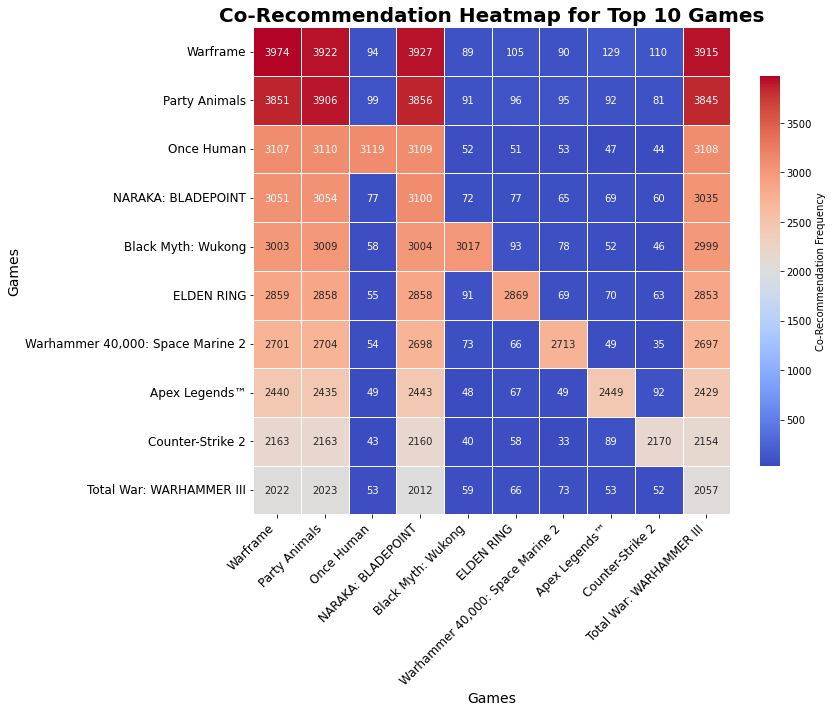

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 10 games by average recommendation scores
top_games = preds_df.drop(columns='cluster', errors='ignore').mean().sort_values(ascending=False).head(10).index

# Create a co-recommendation matrix for the top 10 games
co_recommendation_matrix = preds_df[top_games].T.dot(preds_df[top_games] > 0)

# Enhanced Heatmap Styling
plt.figure(figsize=(12, 10))  # Larger size for better readability
sns.heatmap(
    co_recommendation_matrix, 
    annot=True, 
    fmt=".0f", 
    cmap="coolwarm",  # Modern color palette
    linewidths=0.5,   # Add lines between cells for clarity
    linecolor='white',  # White lines for a clean look
    cbar_kws={'shrink': 0.8, 'label': 'Co-Recommendation Frequency'}  # Custom color bar
)
plt.title("Co-Recommendation Heatmap for Top 10 Games", fontsize=20, fontweight='bold')
plt.xlabel("Games", fontsize=14)
plt.ylabel("Games", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


This code identifies the top 10 games with the highest average recommendation scores, computes a co-recommendation matrix showing how frequently they are recommended together, and visualizes it using an enhanced heatmap with modern styling, clear annotations, and a clean, readable layout.

In [67]:
import plotly.express as px

# Count the frequency of each genre
genres_split = games_description['genres'].str.split(', ', expand=True).stack()
genre_counts = genres_split.value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot genre distribution as a bar chart
fig = px.bar(
    genre_counts.head(15),  # Top 15 genres
    x='genre',
    y='count',
    text='count',
    title='Top 15 Game Genres Distribution',
    labels={'genre': 'Genre', 'count': 'Number of Games'},
    template='plotly_dark'
)
fig.update_traces(marker_color='cyan', textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    title_font_size=20,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    xaxis_tickfont_size=12
)
fig.show()


This code splits the `genres` column into individual genres, calculates their frequency, and visualizes the top 15 genres using a bar chart. The chart, styled with a dark theme and cyan markers, includes clear labels, a tilted x-axis for readability, and game counts displayed above each bar.

In [68]:
import plotly.express as px

# Prepare the data by exploding genres
exploded_genres = games_description.assign(genres=games_description['genres'].str.split(', ')).explode('genres')

# Calculate the average recommendation scores from preds_df
average_recommendations = preds_df.drop(columns='cluster', errors='ignore').mean(axis=0).reset_index(name='avg_recommendation')
average_recommendations.rename(columns={'index': 'game_name'}, inplace=True)

# Merge with exploded genres and group by genre
genre_recommendation = exploded_genres.merge(
    average_recommendations,
    left_on='name',  # 'name' in games_description
    right_on='game_name',  # 'game_name' in average_recommendations
    how='inner'
)
genre_summary = genre_recommendation.groupby('genres').agg(
    avg_recommendation=('avg_recommendation', 'mean'),
    popularity_score=('popularity_score', 'sum'),
    game_count=('name', 'count')
).reset_index()

# Create the interactive bubble plot
fig = px.scatter(
    genre_summary,
    x='avg_recommendation',
    y='genres',
    size='popularity_score',
    color='game_count',
    hover_name='genres',
    hover_data={'avg_recommendation': True, 'popularity_score': True, 'game_count': True},
    title='Interactive Genre vs. Average Recommendation Score',
    labels={'avg_recommendation': 'Average Recommendation Score', 'genres': 'Genres'},
    template='plotly_dark',
    size_max=30
)

# Customize the plot aesthetics
fig.update_traces(
    marker=dict(opacity=0.7, line=dict(width=1, color='DarkSlateGrey'))
)
fig.update_layout(
    title_font_size=20,
    legend_title_font_size=14,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    xaxis_tickfont_size=12,
    yaxis_tickfont_size=12,
)
fig.show()


This code prepares a dataset by exploding game genres, calculates average recommendation scores and popularity for each genre, and visualizes them in an interactive bubble plot. The plot maps average recommendation scores to genres, with bubble sizes representing popularity and colors indicating the number of games per genre, styled with a dark theme for clarity and appeal.

In [69]:
from textblob import TextBlob

# Ensure 'review' column has no NaN values
steam_game_reviews['review'] = steam_game_reviews['review'].fillna('')

# Sentiment Analysis on Reviews
print("Analyzing Sentiments for Game Reviews...")
steam_game_reviews['sentiment'] = steam_game_reviews['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate Average Sentiment for Each Game
print("Calculating Average Sentiment for Each Game...")
game_sentiments = steam_game_reviews.groupby('game_name')['sentiment'].mean().reset_index()
game_sentiments.columns = ['name', 'avg_sentiment']

# Merge with games_description
print("Merging Sentiment Data with Game Descriptions...")
games_with_sentiment = games_description.merge(game_sentiments, on='name', how='left')
games_with_sentiment['avg_sentiment'].fillna(0, inplace=True)  # Fill missing sentiments with 0

# Display Sample Output
print("\nSample Sentiment Analysis Results:")
print(games_with_sentiment[['name', 'avg_sentiment']].head(10))

# Top 5 Most Positively Reviewed Games
top_positive_games = games_with_sentiment.sort_values(by='avg_sentiment', ascending=False).head(5)
print("\nTop 5 Most Positively Reviewed Games:")
print(top_positive_games[['name', 'avg_sentiment']])

# Top 5 Most Negatively Reviewed Games
top_negative_games = games_with_sentiment.sort_values(by='avg_sentiment', ascending=True).head(5)
print("\nTop 5 Most Negatively Reviewed Games:")
print(top_negative_games[['name', 'avg_sentiment']])


Analyzing Sentiments for Game Reviews...
Calculating Average Sentiment for Each Game...
Merging Sentiment Data with Game Descriptions...

Sample Sentiment Analysis Results:
                               name  avg_sentiment
0                Black Myth: Wukong       0.096284
1                  Counter-Strike 2       0.060337
2  Warhammer 40,000: Space Marine 2       0.081683
3                    Cyberpunk 2077       0.000000
4                        ELDEN RING       0.068336
5               PUBG: BATTLEGROUNDS       0.000000
6                     Apex Legends™       0.016510
7                            Dota 2       0.000000
8                     Party Animals       0.089762
9          Total War: WARHAMMER III       0.032950

Top 5 Most Positively Reviewed Games:
                                name  avg_sentiment
13                          Warframe       0.106424
0                 Black Myth: Wukong       0.096284
8                      Party Animals       0.089762
2   Warhammer 40,00

This code performs sentiment analysis on game reviews using TextBlob to calculate polarity scores, computes average sentiment for each game, and merges the results with game descriptions. It identifies the top 5 most positively and negatively reviewed games based on average sentiment, displaying the results for analysis.

In [73]:
# Ensure sentiment exists in reviews
if 'sentiment' not in steam_game_reviews.columns:
    from textblob import TextBlob
    steam_game_reviews['sentiment'] = steam_game_reviews['review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Calculate Bayesian Sentiment
sentiment_mean = steam_game_reviews['sentiment'].mean()
sentiment_count = steam_game_reviews.groupby('game_name')['sentiment'].count()
sentiment_avg = steam_game_reviews.groupby('game_name')['sentiment'].mean()

bayesian_sentiment = (sentiment_avg * sentiment_count + sentiment_mean * 50) / (sentiment_count + 50)
bayesian_sentiment = bayesian_sentiment.reset_index()
bayesian_sentiment.columns = ['name', 'bayesian_sentiment']

# Merge with games_description
games_description = games_description.merge(bayesian_sentiment, on='name', how='left')

# Verify the top 10 games by Bayesian Sentiment
print("Top 10 Games by Bayesian Sentiment:")
print(games_description[['name', 'bayesian_sentiment']].sort_values(by='bayesian_sentiment', ascending=False).head(10))


Top 10 Games by Bayesian Sentiment:
                                name  bayesian_sentiment
13                          Warframe            0.105968
0                 Black Myth: Wukong            0.095779
8                      Party Animals            0.089490
2   Warhammer 40,000: Space Marine 2            0.081402
12                NARAKA: BLADEPOINT            0.072472
4                         ELDEN RING            0.068251
1                   Counter-Strike 2            0.060378
11                        Once Human            0.059563
16                Grand Theft Auto V            0.052357
9           Total War: WARHAMMER III            0.033255


Bayesian Sentiment Adjustment:-
1. Stabilizes sentiment scores for games with few reviews.
2. Highlights games with consistently positive sentiment.

In [71]:
import networkx as nx
import plotly.graph_objects as go

# Filter Top Games for Simplicity
top_games = games_with_sentiment.sort_values(by='popularity_score', ascending=False).head(20)

# Create a Graph
G = nx.Graph()

# Add Nodes with Attributes
for _, row in top_games.iterrows():
    G.add_node(row['name'], 
               popularity=row['popularity_score'], 
               avg_sentiment=row['avg_sentiment'])

# Add Edges Based on Shared Genres
for i, game1 in top_games.iterrows():
    for j, game2 in top_games.iterrows():
        if i < j and set(game1['genres'].split(', ')) & set(game2['genres'].split(', ')):
            G.add_edge(game1['name'], game2['name'])

# Extract Attributes for Plotting
node_x = []
node_y = []
node_size = []
node_color = []

for node in G.nodes(data=True):
    node_x.append(node[0])
    node_y.append(node[1])
    node_size.append(node[1]['popularity'] * 50)  # Scale for visualization
    node_color.append(node[1]['avg_sentiment'])

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = edge[0], edge[1]
    edge_x.append(x0)
    edge_y.append(y0)

# Plot the Graph with Plotly
fig = go.Figure()

# Add Edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
))

# Add Nodes
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='RdYlGn',
        colorbar=dict(title='Avg Sentiment'),
        line_width=2
    ),
    text=[f"{node[0]}<br>Popularity: {node[1]['popularity']:.2f}<br>Avg Sentiment: {node[1]['avg_sentiment']:.2f}" for node in G.nodes(data=True)],
    hoverinfo='text'
))

# Final Layout Adjustments
fig.update_layout(
    title="Game Relationship Network",
    showlegend=False,
    margin=dict(l=0, r=0, t=40, b=0),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig.show()


This code constructs a graph using the top 20 games based on popularity, with nodes representing games and edges linking games that share genres. It uses networkx to create the graph and plotly for interactive visualization, where node size reflects popularity, node color represents average sentiment, and edges show genre relationships. The result is a visually intuitive game relationship network.